# Velobikes

### Y = 

In [27]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
import theano.tensor as T
import theano
import matplotlib.pyplot as plt
f = pd.read_csv("data.csv")
import lasagne

### Загружаем данные о велостанциях по часам

In [28]:
f = f.ix[:,1:f.shape[1]]
d = f
d.head(10)

,2016-04-21T08:00:00,2016-04-21T09:00:00,2016-04-21T10:00:00,2016-04-21T11:00:00,2016-04-21T12:00:00,2016-04-21T13:00:00,2016-04-21T14:00:00,2016-04-21T15:00:00,2016-04-21T16:00:00,2016-04-21T17:00:00,...,2016-07-01T04:00:00,2016-07-01T05:00:00,2016-07-01T06:00:00,2016-07-01T07:00:00,2016-07-01T08:00:00,2016-07-01T09:00:00,2016-07-01T10:00:00,2016-07-01T11:00:00,2016-07-01T12:00:00,2016-07-01T13:00:00
0,10,10.0,10.0,10.000000,10.000000,10.000000,10.103064,10.284010,10.359081,10.293135,...,9.247622,9.246876,9.246141,9.245944,9.244484,9.242877,9.243557,9.244633,9.246790,9.248279
1,7,7.0,7.0,6.750000,6.562500,6.451505,6.376045,6.322196,6.281837,6.168831,...,4.740542,4.740099,4.739657,4.738747,4.736397,4.733770,4.734157,4.734912,4.735516,4.735673
2,4,4.0,4.0,4.311111,4.483333,4.585284,4.654596,4.844869,4.989562,5.102041,...,3.671111,3.670709,3.670020,3.668684,3.666494,3.664774,3.664448,3.664787,3.664034,3.663351
3,5,5.0,5.0,5.000000,5.241667,5.488294,5.682451,5.727924,5.872651,5.829314,...,6.158427,6.158332,6.158238,6.158113,6.159312,6.161335,6.162808,6.163099,6.163150,6.163916
4,5,4.4,4.7,4.800000,4.850000,4.879599,4.693593,4.451074,4.281837,4.139147,...,4.874060,4.874135,4.874211,4.874793,4.875843,4.876215,4.876498,4.876144,4.875533,4.873683
5,4,4.0,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.005566,...,4.087769,4.087119,4.086469,4.086387,4.086793,4.085926,4.085279,4.084841,4.084016,4.083024
6,8,8.0,7.0,6.000000,5.500000,5.204013,5.002786,4.780430,4.486430,4.274583,...,3.039058,3.039035,3.039012,3.038988,3.039045,3.039031,3.039276,3.039849,3.039994,3.039940
7,4,4.0,4.0,4.000000,3.945833,3.759197,3.632312,3.541766,3.473904,3.322820,...,3.328371,3.327806,3.327610,3.328250,3.328582,3.327541,3.325686,3.326366,3.326519,3.330133
8,5,5.0,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.996289,...,4.510051,4.510344,4.510298,4.511098,4.511768,4.513829,4.516126,4.518201,4.518875,4.519112
9,3,3.0,3.2,3.383333,3.287500,3.086957,3.189415,3.305489,3.392484,3.306122,...,4.176944,4.177057,4.178216,4.180827,4.182391,4.183057,4.182670,4.182094,4.182651,4.180866


выбираем утренние часы(X) и вечерний час(Y)

In [29]:
def hours(time):
    hour = parse(str(time)).hour
    return hour
data_set = []
data_set_Y = []

for i in f:
    time = i
    if (hours(time) >= 8 and hours(time) <=12):
        data_set.append(i)
    if (hours(time) == 19):
        data_set_Y.append(i)

Выбираем соответствующие столбцы данных

In [30]:
D = []
Y = []
buf = []
ind = 0
for i in data_set:
   D.append(list(f[i]))

for i in data_set_Y:
    Y.append(list(f[i]))

In [31]:
D = pd.DataFrame(D)
Y = pd.DataFrame(Y)

In [32]:
YY = []
for i in Y:
    YY.append(Y[i])

In [33]:
X = [np.array(D[i]) for i in D]

In [34]:
XX = []
for i in xrange(len(X)):
    X1 = []
    ind = 0
    while ind < len(X[i]) - 10:
        X1.append(X[i][ind:ind+5])
        ind = ind + 5
    XX.append(X1)



Формат данных: в XX (станции, дни, часы) = загруженность, YY (станции, дни) = загруженность
т.е. XX[0][3][0] = для третьего дня, для "8" часов утра какая была загруженность "0" станции
    YY[1][2] = для второго дня, для 19 часов вечера какая была загруженность "1" станции
Соответсятвенно, от нейронки мы будем ждать предсказание вечерней загруженности по утренней.


In [35]:
input_X = T.matrix("XX", dtype='float64')
target_y = T.vector("Vec", dtype='float64')
input_shape = [None, 5]
rate = theano.shared(0.01)

Создадим два скрытых слоя с 20 нейронами, сигмоидальной активационной функцией.

In [36]:
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

dense_layer_1 = lasagne.layers.DenseLayer(input_layer, num_units= 10, nonlinearity= lasagne.nonlinearities.sigmoid,  
                                          name = "hidden_dense_layer_1")
dense_layer_1 = lasagne.layers.DenseLayer(dense_layer_1, num_units= 20, nonlinearity= lasagne.nonlinearities.sigmoid,  
                                          name = "hidden_dense_layer_1")
dense_layer_1 = lasagne.layers.DenseLayer(dense_layer_1, num_units= 10, nonlinearity= lasagne.nonlinearities.sigmoid,  
                                          name = "hidden_dense_layer_1")
dense_layer_1 = lasagne.layers.DenseLayer(dense_layer_1, num_units= 7, nonlinearity= lasagne.nonlinearities.sigmoid,  
                                          name = "hidden_dense_layer_1")


output_layer = lasagne.layers.DenseLayer(dense_layer_1, num_units= 1, 
                                         nonlinearity= lasagne.nonlinearities.linear,name = "output_layer")

In [37]:
y_predicted = lasagne.layers.get_output(output_layer)

In [38]:
all_weights = lasagne.layers.get_all_params(output_layer)

In [39]:
loss = lasagne.objectives.squared_error(y_predicted,target_y).mean()

In [40]:
accuracy = lasagne.objectives.squared_error(y_predicted,target_y).mean()

In [41]:
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=rate)

In [42]:
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd, allow_input_downcast= True)

In [43]:
accuracy_fun = theano.function([input_X,target_y],[loss, accuracy], allow_input_downcast= True)



## Обучим нейронку

In [56]:

import math
all_err = []
gr = []
graph = []

for j in range(len(XX) - 1):
    #print "Station",j, ":"
    train_x = XX[j][:50]
    train_y = YY[j][:50].reshape(-1, 1)
    check_x = XX[j][51:]
    check_y = YY[j][51:].reshape(-1, 1)
   
    for i in range(10):
        cnt = 0
        for a, b in zip(train_x, train_y):
            l, c = train_fun(a.reshape(1, -1), b)
            gr.append((l, j, cnt))
            rate=rate*0.99
            cnt += 1
   # print "#Start checking error"
    for a, b in zip(check_x, check_y):
        
        l, c = train_fun(a.reshape(1, -1), b)
        all_err.append(l)
        #print "error = ", l, "|  100%*(1-sqrt(err)) = ", 100 - math.sqrt(l)*100
        graph.append(l)
print "mean_err =", np.mean(all_err)
print "mean 100%*(1-sqrt(err)) =", 100*(1 - math.sqrt(np.mean(all_err)))

mean_err = 0.00484260199563
mean 100%*(1-sqrt(err)) = 93.041119346


Нарисуем графики
1) check
2) train

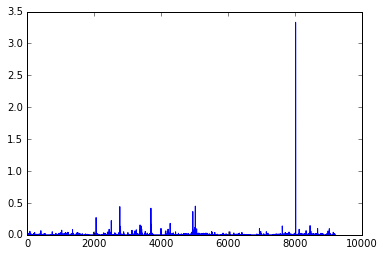

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(graph)

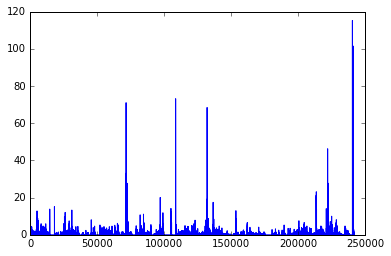

In [50]:
#train errors
plt.plot(gr)
rate = 0.01

In [62]:
wows = []
mx = 60
for i in xrange(len(gr)):
    if (gr[i][0]) > mx:
        wows.append(gr[i])

In [63]:
wows

[(array(67.83794019372948), 143, 2),
 (array(67.2645129465548), 143, 3),
 (array(84.38816024385041), 145, 0),
 (array(69.06509080122208), 145, 1),
 (array(72.94355332351877), 217, 0),
 (array(68.20703222961774), 264, 0),
 (array(81.96746104094257), 481, 2),
 (array(107.33707167897603), 481, 3),
 (array(103.40715103841224), 481, 4),
 (array(117.63573177715925), 481, 5),
 (array(120.16260758126695), 481, 6),
 (array(88.620700841758), 481, 7),
 (array(77.4051361721008), 481, 8),
 (array(101.58925533705708), 482, 0),
 (array(88.07585221490444), 482, 0)]

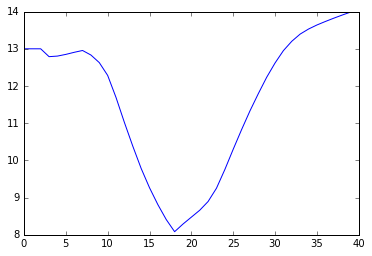

In [84]:
list(f.ix[484,:])
plt.plot(list(list(f.ix[481,:]))[:40])